<div style='background-color:#d100fb; font-size:50px; color:#000000; font-weight:bold;padding:20px'> PIG-E </div>

<div style='font-size:30px; padding:5px'> Example using batch of materials properties </div>
Using Thermo-Calc data calculated for carbides for a material in Speich et al. <br>
[Speich, er al., Metall Trans 4, 303–315 (1973). https://doi.org/10.1007/BF02649630] 

<div style='background-color:#ed95ff; font-size:14px; color:#000000; font-weight:bold; padding:5px'> Necessary modules </div>

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import shutil
import multiprocessing
np.seterr(divide='ignore'); # stop printing a runtime that can happen...

from PIG_E import *

In [2]:
#
# Get Material Lists - from CrystalProperties
#
PrecipitateList = GetPrecipitateList()
PhaseElements = GetPhaseElements()
MatrixPh = GetMatrixPhase()[0]

In [3]:
#
# Configure path to data files and generate file names
#
DataPath = os.getcwd()
file_nos = np.arange(0,8,1)
FileNames = [f'SpeichData_{i}_SYSTEMREDUCED' for i in file_nos] # this is Alloy C in Speich 1973 Met Trans

In [4]:
#
# Example batch calculation for carbides in the first Speich file. All files were precalculated to reduce computation time.
#
FileName = FileNames[0] 
File = f'{FileName}.csv'

# load inputs into a dataframe
SystemIN = pd.read_csv(fr'{DataPath}/Data/{File}', index_col=0)

# create dataframe for results
OutputEnergyFrame = pd.DataFrame()

In [5]:
#
# MATRIX information - from CrystalProperties 
#
PhaseComposition = {elem : SystemIN.loc[MatrixPh][f'at comp {elem}'] for elem in PhaseElements if f'at comp {elem}' in SystemIN.columns}

Matrix = CrystalProperties(MatrixPh,                            # crystal structure
                              PhaseComposition,                 # composition OF PHASE
                              SystemIN.loc[MatrixPh]['T'],      # temperature
                              SystemIN.loc[MatrixPh]['VM'])     # molar volume

#
# runs the find elastic constants and lattice parameter functions
# LatticeParameter() must come before ElasticConstants()
#
Matrix.LatticeParameters()
Matrix.ElasticConstants()

OutputEnergyFrame.loc[MatrixPh,'a'] = Matrix.a
OutputEnergyFrame.loc[MatrixPh,'b'] = Matrix.b
OutputEnergyFrame.loc[MatrixPh,'c'] = Matrix.c
OutputEnergyFrame.loc[MatrixPh,'Poisson'] = Matrix.Poisson
OutputEnergyFrame.loc[MatrixPh,'ShearModulus'] = Matrix.ShearModulus

In [6]:
#
# Iterating through precipitate phases
#

for Precipitate in PrecipitateList:
    #loop over all potential precipitates from STEEL_Info

    # some systems will not have all 12 carbides. Calculations are only run for carbides present in the input file
    if Precipitate in SystemIN.index:

        #
        # Precipitate Information - from CrystalProperties 
        #
        PrecipComposition = {elem : SystemIN.loc[Precipitate][f'at comp {elem}'] for elem in PhaseElements if f'at comp {elem}' in SystemIN.columns}

        Precip = CrystalProperties(Precipitate,            # crystal structure
                              PrecipComposition,                  # composition OF PHASE
                              SystemIN.loc[Precipitate]['T'],    # temperature
                              SystemIN.loc[Precipitate]['VM'])   # molar volume

        #
        # runs the find elastic constants and lattice parameter functions
        #
        Precip.LatticeParameters()
        Precip.ElasticConstants()

        #
        # Reporting the information to an output dataframe
        #
        OutputEnergyFrame.loc[Precipitate,'a'] = Precip.a
        OutputEnergyFrame.loc[Precipitate,'b'] = Precip.b
        OutputEnergyFrame.loc[Precipitate,'c'] = Precip.c
        OutputEnergyFrame.loc[Precipitate,'Poisson'] = Precip.Poisson
        OutputEnergyFrame.loc[Precipitate,'ShearModulus'] = Precip.ShearModulus

        #
        # Orientation relationship information (Transformation Matrix and burgers vectors)
        #
        ORinfo = CrystalInterface(Matrix, Precip)
        ORinfo.GetInterfaces()

        #
        # Interfacial Energy
        #
        for Interface in ORinfo.FBToA.keys():

            #create an interfactial energy solver object
            Solution = NonSingularIsotropicBimaterialInterfaceEnergy(Matrix, Precip, Interface, ORinfo)

            #calculate elastic interfacial energy
            OutputEnergyFrame.loc[Precipitate,Interface] = Solution.InterfaceEnergy

            #report the phase, OR, and elastic interfacial energy
            print(f"for {Precipitate} with {Interface} the interfacial energy is {Solution.InterfaceEnergy} J/m2")

SystemOUT = SystemIN.merge(OutputEnergyFrame, how='outer', left_index=True, right_index=True)
SystemOUT.to_csv(f'{DataPath}/Data/{FileName}_OUTPUT_new.csv')


for M23C6_D84 with Bain the interfacial energy is 0.45037287695065187 J/m2
for M23C6_D84 with KurdjumovSachs the interfacial energy is 0.45410561719160086 J/m2
for M23C6_D84 with NishiyamaWasserman the interfacial energy is 0.4471121404408089 J/m2
for M23C6_D84 with Pitsch the interfacial energy is 0.3759948141200959 J/m2
for FE4N_LP1 with Bain the interfacial energy is 0.3774479842980628 J/m2
for FE4N_LP1 with KurdjumovSachs the interfacial energy is 0.36970913959919444 J/m2
for FE4N_LP1 with NishiyamaWasserman the interfacial energy is 0.3776960504606176 J/m2
for FE4N_LP1 with Pitsch the interfacial energy is 0.30912988033975614 J/m2
for KSI_CARBIDE with KSI_CARBIDE the interfacial energy is 0.3142452335841422 J/m2
for M5C2 with Fe5C2 the interfacial energy is 0.9104104204921916 J/m2
for HCP_A3#2 with Burgers the interfacial energy is 0.48613360896943325 J/m2
for HCP_A3#2 with PitschSchrader the interfacial energy is 0.663831943429573 J/m2
for M7C3_D101 with Bagaryatski the interfaci

Lets look at output file...

In [7]:
SystemOUT.head()

,T,VM,at comp C,at comp Co,at comp Cr,at comp Mn,at comp N,at comp Ni,at comp Si,sigma,...,Bain,KurdjumovSachs,NishiyamaWasserman,Pitsch,KSI_CARBIDE,Fe5C2,Burgers,PitschSchrader,Bagaryatski,Isaichev
BCC_A2,478.15,0.000007,3.000000e-12,9.134765e-02,0.000481,8.150700e-04,3.000000e-12,4.628335e-03,2.190000e-09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CEMENTITE_D011,478.15,0.000006,2.500000e-01,2.990000e-08,0.697437,3.822101e-02,2.500000e-13,8.400000e-05,7.500000e-13,0.26155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.748008,0.476449
FE4N_LP1,478.15,0.000007,1.999997e-01,3.450060e-04,0.025474,2.959908e-03,2.680000e-07,9.819907e-03,0.000000e+00,0.15998,...,0.377448,0.369709,0.377696,0.30913,NaN,NaN,NaN,NaN,NaN,NaN
HCP_A3#2,478.15,0.000006,3.332970e-01,6.150000e-07,0.666701,3.490000e-09,1.430000e-06,2.950000e-07,6.670000e-13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.486134,0.663832,NaN,NaN
KSI_CARBIDE,478.15,0.000007,2.500000e-01,0.000000e+00,0.181606,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.17192,...,NaN,NaN,NaN,NaN,0.314245,NaN,NaN,NaN,NaN,NaN


Now we will load all of the data files from the Speich dataset.

In [8]:
#
# Load all output files from batch calculation
#

df = {}
for i, FileName in enumerate(FileNames):
    #loop over all files and merge into a single dataframe
    if i == 0:
        df = pd.read_csv(fr'{DataPath}/Data/{FileName}_OUTPUT_new.csv', index_col=0)
    else:
        df = pd.concat([df,pd.read_csv(fr'{DataPath}/Data/{FileName}_OUTPUT_new.csv', index_col=0)])
        
df.reset_index(inplace=True)
df.rename(columns={'index':'Phase'},inplace=True)
df.head()
          

,Phase,T,VM,at comp C,at comp Co,at comp Cr,at comp Mn,at comp N,at comp Ni,at comp Si,...,NishiyamaWasserman,Pitsch,KSI_CARBIDE,Fe5C2,Burgers,PitschSchrader,Bagaryatski,Isaichev,dG,precip check
0,BCC_A2,478.15,0.000007,3.000000e-12,9.134765e-02,0.000481,8.150700e-04,3.000000e-12,4.628335e-03,2.190000e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEMENTITE_D011,478.15,0.000006,2.500000e-01,2.990000e-08,0.697437,3.822101e-02,2.500000e-13,8.400000e-05,7.500000e-13,...,NaN,NaN,NaN,NaN,NaN,NaN,0.748008,0.476449,NaN,NaN
2,FE4N_LP1,478.15,0.000007,1.999997e-01,3.450060e-04,0.025474,2.959908e-03,2.680000e-07,9.819907e-03,0.000000e+00,...,0.377696,0.30913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HCP_A3#2,478.15,0.000006,3.332970e-01,6.150000e-07,0.666701,3.490000e-09,1.430000e-06,2.950000e-07,6.670000e-13,...,NaN,NaN,NaN,NaN,0.486134,0.663832,NaN,NaN,NaN,NaN
4,KSI_CARBIDE,478.15,0.000007,2.500000e-01,0.000000e+00,0.181606,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,0.314245,NaN,NaN,NaN,NaN,NaN,NaN,NaN


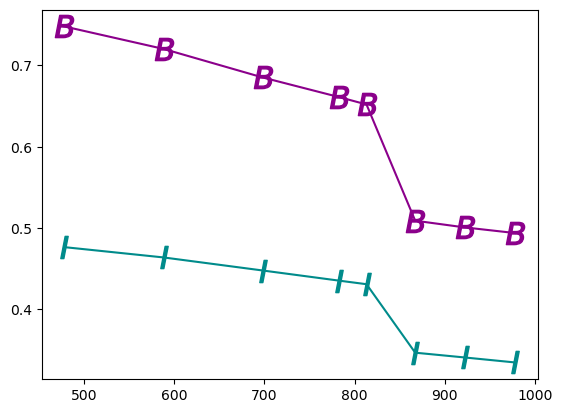

In [9]:
#
# Plot resulting elastic interfacial energy for CEMENTITE_D011
#
plt.plot(df[df['Phase']=='CEMENTITE_D011']['T'],df[df['Phase']=='CEMENTITE_D011']['Bagaryatski'],
         marker='$B$', ms=16, color='darkmagenta', label='Bagaryatski')
plt.plot(df[df['Phase']=='CEMENTITE_D011']['T'],df[df['Phase']=='CEMENTITE_D011']['Isaichev'],
         marker='$I$', ms=16, color='darkcyan', label='Isaichev')

You can see that the interfacial energy changes both with orientation relationship and temperature. In this case the Isaichev OR results in a more coherent interface. The interfacial energy changes with temperature due the changes in composition, lattice parameters, and elastic constants, as illustrated below.

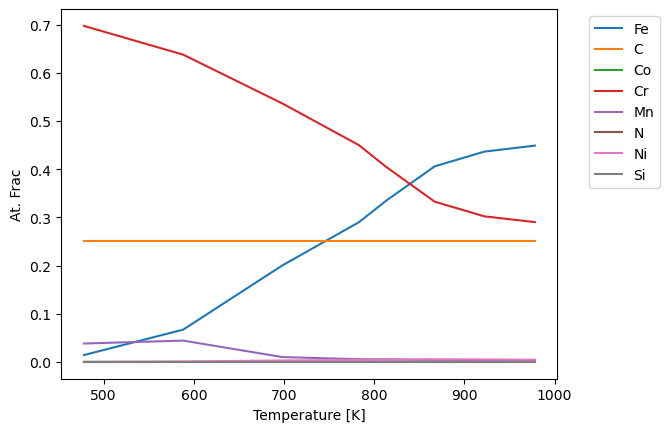

In [10]:
#
# Plot CEMENTITE_D011 composition as a function temperature
#

f, ax = plt.subplots()
elems = ['Fe', 'C','Co','Cr','Mn','N','Ni','Si']
for elem in elems:
    ax.plot(df[df['Phase']=='CEMENTITE_D011']['T'],df[df['Phase']=='CEMENTITE_D011'][f'at comp {elem}'],label=elem)

ax.set(xlabel='Temperature [K]',ylabel='At. Frac')
ax.legend(bbox_to_anchor=(1.05, 1))

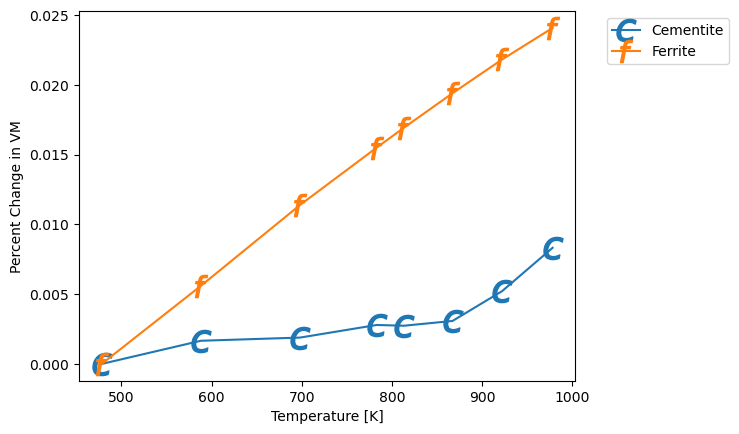

In [11]:
#
# Plot percent change in molar volume for CEMENTITE_D011 and BCC_A2 as a function temperature
#

f, ax = plt.subplots()
ax.plot(df[df['Phase']=='CEMENTITE_D011']['T'],
        (df[df['Phase']=='CEMENTITE_D011']['VM']-df[df['Phase']=='CEMENTITE_D011']['VM'].values[0])/df[df['Phase']=='CEMENTITE_D011']['VM'].values[0],
        marker='$c$',ms=16,label='Cementite')
ax.plot(df[df['Phase']=='BCC_A2']['T'],
        (df[df['Phase']=='BCC_A2']['VM']-df[df['Phase']=='BCC_A2']['VM'].values[0])/df[df['Phase']=='BCC_A2']['VM'].values[0],
       marker='$f$',ms=16,label='Ferrite')
ax.set(xlabel='Temperature [K]',ylabel='Percent Change in VM')
ax.legend(bbox_to_anchor=(1.05, 1))

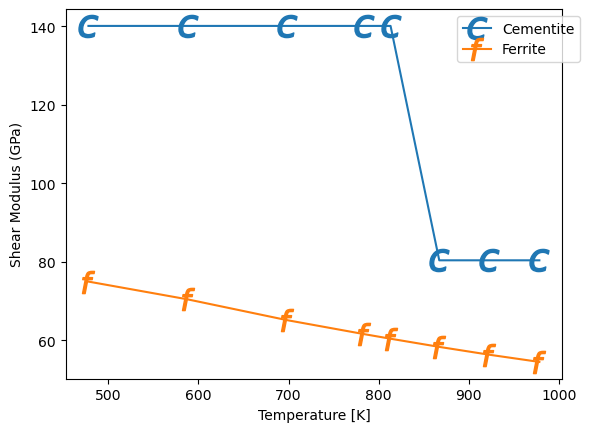

In [12]:
#
# Plot shear modulus for CEMENTITE_D011 and BCC_A2 as a function temperature
#

f, ax = plt.subplots()
ax.plot(df[df['Phase']=='CEMENTITE_D011']['T'],df[df['Phase']=='CEMENTITE_D011']['ShearModulus'],marker='$c$',ms=16,label='Cementite')
ax.plot(df[df['Phase']=='BCC_A2']['T'],df[df['Phase']=='BCC_A2']['ShearModulus'],marker='$f$',ms=16,label='Ferrite')
ax.set(xlabel='Temperature [K]',ylabel='Shear Modulus (GPa)')
ax.legend(bbox_to_anchor=(1.05, 1))

The evolution of the elastic interfacial energy can then be examined for all carbides as a functionof temperature.

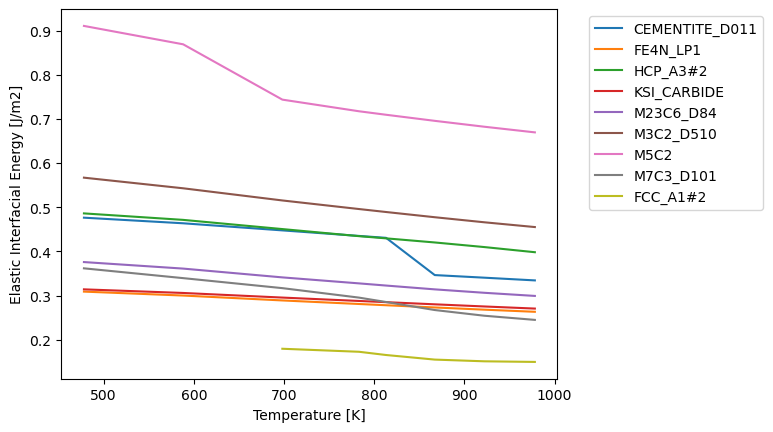

In [13]:
#
# Plot the minimum elastic interfacial energy for a given carbide
#

ORdict = GetPrecipitateORs()
f, ax = plt.subplots()
ax.set(xlabel='Temperature [K]',ylabel='Elastic Interfacial Energy [J/m2]')
for Phase in df['Phase'].unique():
    if Phase == 'BCC_A2':
        continue
    ax.plot(df[df['Phase']==Phase]['T'],df[df['Phase']==Phase][ORdict[Phase]].apply(np.min,axis=1),label=f'{Phase}')
ax.legend(bbox_to_anchor=(1.05, 1))

Finally, the total interfacial energy for each carbide is determined by adding the chemical contribution.

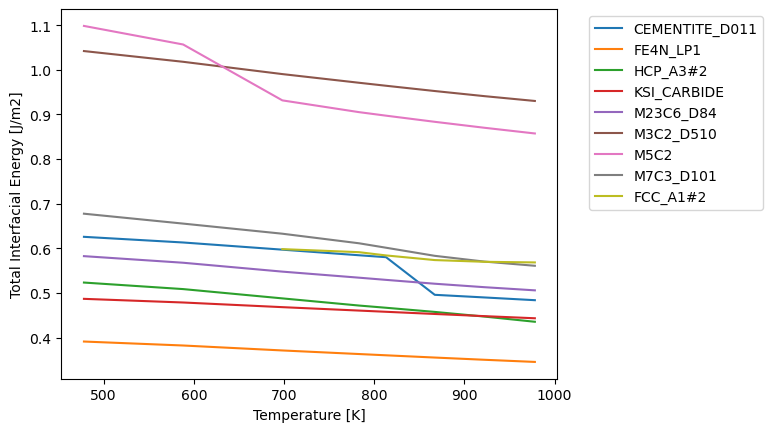

In [14]:
#
# Plot the total interfacial energy for a given carbide
#

f, ax = plt.subplots()
ax.set(xlabel='Temperature [K]',ylabel='Total Interfacial Energy [J/m2]')
for Phase in df['Phase'].unique():
    if Phase == 'BCC_A2':
        continue
    ax.plot(df[df['Phase']==Phase]['T'],df[df['Phase']==Phase]['InterfaceE_chem']+df[df['Phase']==Phase][ORdict[Phase]].apply(np.min,axis=1),label=f'{Phase}')
ax.legend(bbox_to_anchor=(1.05, 1))